# Chatbot with HyDE

## 1. 패키지

In [22]:
import os
import re
import glob
import faiss
import tiktoken
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from operator import itemgetter
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from langchain.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnableMap
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint, HuggingFaceEndpointEmbeddings

## 2. 데이터

In [23]:
def transform_markdown_headers(text: str) -> str:
    """
    주어진 텍스트의 모든 마크다운 헤더를 아래의 형식으로 변환하는 함수
        ## 1            -> ## 1
        ## 1.1          -> ### 1.1
        ## 1.1.1        -> #### 1.1.1
        ## 1.1.1.1      -> ##### 1.1.1.1
    """
    pattern = re.compile(r'^(##)\s+(\d+(?:\.\d+)*)(.*)$', re.MULTILINE)

    def repl(match: re.Match) -> str:
        nums = match.group(2)
        rest = match.group(3)
        new_level = 2 + nums.count('.')
        
        return f'{"#" * new_level} {nums}{rest}'

    return pattern.sub(repl, text)

In [24]:
def transform_number_headers(text: str) -> str:
    """
    주어진 텍스트의 모든 숫자형식 헤더를 아래의 형식으로 변환하는 함수
    "- 1.1"       -> "### 1.1"
    "- 1.1.1"     -> "#### 1.1.1"
    "- 1.1.1.1"   -> "##### 1.1.1.1"
    """
    pattern = re.compile(r'(?m)^\-\s+(\d+(?:\.\d+)*)(.*)$')

    def repl(match: re.Match) -> str:
        nums = match.group(1)
        rest = match.group(2)
        new_level = 2 + nums.count('.')
        
        return f'{"#" * new_level} {nums}{rest}'

    return pattern.sub(repl, text)

### 1) PDF 파일 로드 및 마크다운 변환

In [ ]:
# PDF 파일경로
filepath_list = [
    "[INPUT YOUR PDF FILEPATH]"
]

In [6]:
# PDF 로드 및 1차 변환 ("#" 형식 마크다운 헤더 추가)
converted_pdf_list = []
converter = DocumentConverter()
for filepath in tqdm(filepath_list):
    converted_pdf = converter.convert(filepath)
    converted_pdf_list.append(converted_pdf)

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# 마크다운 변환 텍스트 추출
markdown_txt_list = []
for converted_pdf in tqdm(converted_pdf_list):
    markdown_txt_list.append(converted_pdf.document.export_to_markdown(image_placeholder=""))

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# PDF 2차 변환 ("#" 형식 마크다운 헤더 추가 변환) // 각 문서별 특징에 맞게 변환 수행
converted_markdown_txt_list = []
for markdown_txt in tqdm(markdown_txt_list):
    title = markdown_txt.split("\n\n")[0].replace("##", "").strip()
    if title == "[EXAMPLE TITLE]":
        content = "\n\n".join(markdown_txt.split("## EXAMPLE SPLIT TITLE")[1:]).strip()
        converted_content = transform_number_headers(transform_markdown_headers(content))
    else:
        content = markdown_txt.split("## EXAMPLE SPLIT TITLE")[-1].strip()
        converted_content = transform_markdown_headers(content)
    converted_markdown_txt_list.append(f"# {title}\n\n{converted_content}")

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# 저장
for i, converted_markdown_txt in enumerate(converted_markdown_txt_list):
    with open(f"[INPUT YOUR PATH]{i+1}.txt", "w", encoding="utf-8") as fp:
        fp.write(converted_markdown_txt)

### 2) 문서 청킹

In [10]:
# 변환된 데이터 불러오기
converted_markdown_txt_list = []
converted_markdown_txt_filepath_list = glob.glob("../../data/*.txt")
for converted_markdown_txt_filepath in tqdm(converted_markdown_txt_filepath_list):
    with open(converted_markdown_txt_filepath, "r", encoding="utf-8") as fp:
        converted_markdown_txt_list.append(fp.read())

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# Markdown Header Splitter 정의
markdown_header_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=[
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
        ("####", "Header 4"),
        ("#####", "Header 5")
    ]
)

In [12]:
# 문서 청킹 수행
chunks = []
for converted_markdown_txt in tqdm(converted_markdown_txt_list):
    chunks += markdown_header_splitter.split_text(converted_markdown_txt)

  0%|          | 0/2 [00:00<?, ?it/s]

### 3) 청크 사이즈 분포 시각화

In [13]:
# 청크 사이즈 계산 : LLM이 인식하는 토큰 단위로 분할하여 계산
tiktoken_encoder = tiktoken.get_encoding("cl100k_base")
chunk_sizes = [len(tiktoken_encoder.encode(chunk.page_content)) for chunk in chunks]

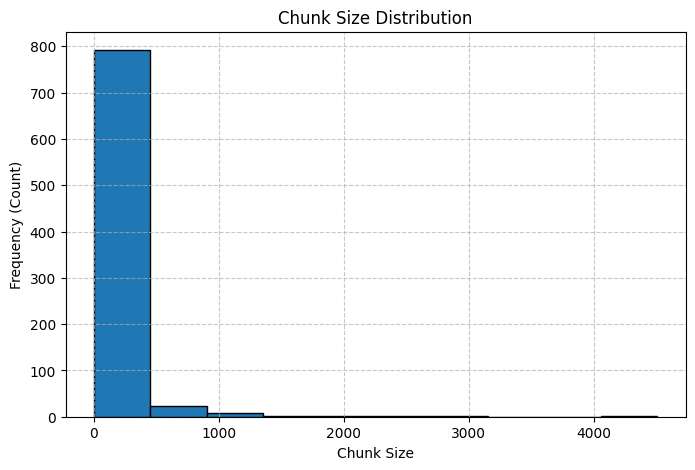

In [14]:
# 시각화
plt.figure(figsize=(8, 5))
plt.hist(chunk_sizes, bins=10, edgecolor="black")
plt.title('Chunk Size Distribution')
plt.xlabel('Chunk Size')
plt.ylabel('Frequency (Count)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 4) 청크 후처리

In [15]:
# Chunk Size가 2,000 이상인 Chunk에 대해 후처리 수행: 더 작은 사이즈로 청킹
# 규칙 기반 문장 단위 청킹을 위해 Recursive Character Text Splitter 사용
recursive_character_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    separators=["\n\n", "\n", ".", " "]
)

# 청킹 재수행
new_chunks = []
for chunk, chunk_size in zip(chunks, chunk_sizes):
    if chunk_size < 1000:
        new_chunks.append(chunk)
    else:
        splits = recursive_character_text_splitter.split_text(chunk.page_content)
        for split in splits:
            new_chunks.append(Document(
                metadata=chunk.metadata,
                page_content=split
            ))

### 5) 청크 사이즈 분포 시각화(후처리 적용)

In [16]:
# 청크 사이즈 계산 : LLM이 인식하는 토큰 단위로 분할하여 계산
chunk_sizes = [len(tiktoken_encoder.encode(chunk.page_content)) for chunk in new_chunks]

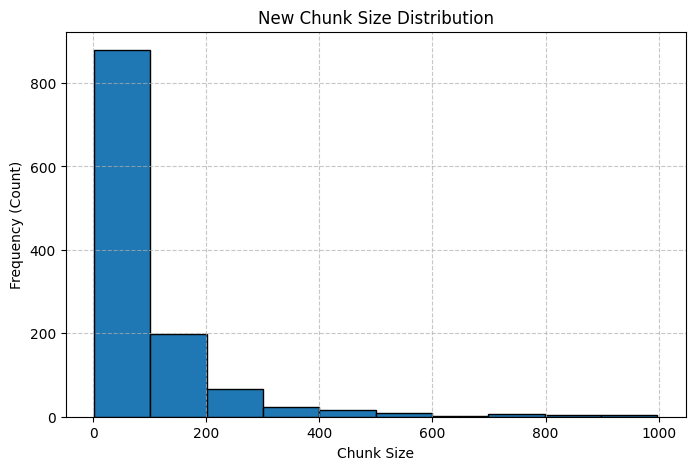

In [17]:
# 시각화
plt.figure(figsize=(8, 5))
plt.hist(chunk_sizes, bins=10, edgecolor="black")
plt.title('New Chunk Size Distribution')
plt.xlabel('Chunk Size')
plt.ylabel('Frequency (Count)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 3. 벡터 데이터베이스

In [26]:
def get_batch(iterable, batch_size):
    """Batch Size대로 Batch를 만들어주는 함수"""
    l = len(iterable)
    for ndx in range(0, len(iterable), batch_size):
        yield iterable[ndx:min(ndx + batch_size, l)]

### 1) 임베딩 모델 로드

In [ ]:
# Qwen/Qwen3-Embedding-8B 모델 사용 (SOTA 모델) // Text Embedding Inference Server 사용
embedding_model = HuggingFaceEndpointEmbeddings(
    model="[INPUT YOUR ENDPOINT URL]"
)
dimension_size = len(embedding_model.embed_query("query"))

### 2) 벡터DB - Standard Document

In [ ]:
# FAISS DB 생성
relevant_info_db = FAISS(
    embedding_function=embedding_model,
    index=faiss.IndexFlatL2(dimension_size),
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [ ]:
# Max Batch 32 제약으로 인한 청크 chunk batch size 조정
for batched_documents in get_batch(new_chunks, 32):
    relevant_info_db.add_documents(batched_documents)

### 3) 벡터DB - Relevant QA

In [ ]:
# QA 데이터 로드
df = pd.read_excel("[INPUT YOUR DATA PATH]", engine="openpyxl", header=0)

In [ ]:
# Documents 생성
qa_documents = []
for i in range(len(df)):
    qa_documents.append(
        Document(
            page_content=df["Q"][i],
            metadata={"title": "Relevant QA", "content": df["A"][i]}
        )
    )

In [ ]:
# FAISS DB 생성
relevant_qa_db = FAISS(
    embedding_function=embedding_model,
    index=faiss.IndexFlatL2(dimension_size),
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [ ]:
# Max Batch 32 제약으로 인한 청크 chunk batch size 조정
for batched_documents in get_batch(qa_documents, 32):
    relevant_qa_db.add_documents(batched_documents)

### 4) 벡터DB - Relevant PPT

In [ ]:
# PPT 데이터 로드
ppt_filepath_list = glob.glob("[INPUT YOUR PPT PATH]")

In [ ]:
# Document 생성
ppt_documents = []
for ppt_filepath in ppt_filepath_list:
    ppt_documents.append(
        Document(
            page_content=os.path.basename(ppt_filepath_list[0]),
            metadata={"source": ppt_filepath}
        )
    )

In [ ]:
# FAISS DB 생성
relevant_ppt_db = FAISS(
    embedding_function=embedding_model,
    index=faiss.IndexFlatL2(dimension_size),
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [ ]:
# Max Batch 32 제약으로 인한 청크 chunk batch size 조정
for batched_documents in get_batch(ppt_documents, 32):
    relevant_ppt_db.add_documents(batched_documents)

## 4. 챗봇

### 1) LLM 로드

In [ ]:
llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        endpoint_url="[INPUT YOUR ENDPOINT URL]",
        top_k=10,
        top_p=0.95,
        typical_p=0.95,
        temperature=0.5,
        max_new_tokens=32768,
        repetition_penalty=1.05,
        stop_sequences=["<|im_end|>"],
    )
)

### 2) LLM Retrieval 정의

In [ ]:
# Relevant Info Retrieval: Standard Document
# 검색 개수 설정
relevant_info_k = 3

def get_relevant_information(vector: list) -> str:
    """사용자의 질문과 관련된 정보를 벡터DB에서 검색하여 반환하는 함수"""
    # 검색
    results = relevant_info_db.similarity_search_by_vector(embedding=vector, k=relevant_info_k)

    # 결과 포맷팅
    content_list = []
    for result in results:
        titles = []
        for i, key in enumerate(result.metadata.keys()):
            titles.append(f"{(i+1) * '#'} {result.metadata[key]}")
        title = "\n".join(titles)
        content = result.page_content
        content_list.append(f"{title}\n{content}")
    
    return "\n\n".join(content_list)

In [ ]:
# Relevant QA Retrieval: Relevant QA
# 검색 개수 설정
relevant_qa_k = 3

def get_relevant_qa(message: str) -> str:
    """사용자의 질문과 관련된 가이드라인을 벡터DB에서 검색하여 반환하는 함수"""
    # 검색
    results = relevant_qa_db.similarity_search(query=message, k=relevant_qa_k)

    # 포맷팅
    content_list = []
    for result in results:
        title = result.metadata["title"]
        content = result.metadata["content"]

        content_list.append(f"# {title}\n{content}")
    
    return "\n\n".join(content_list)

In [ ]:
# Relavant PPT Retrieval: Relevant PPT
# 검색 개수 설정
relevant_qa_k = 1

def get_relevant_ppt(message: str) -> str:
    """사용자의 질문에 도움이되는 시험 방법 PPT를 반환하는 함수"""
    # 검색
    results = relevant_ppt_db.similarity_search(query=message, k=relevant_qa_k)

    # 포맷팅
    content_list = []
    for result in results:
        source = result.metadata["source"]
        content_list.append(f"- {source}")
    
    return "\n".join(content_list)

### 3) Prompt Template 정의

In [ ]:
# Prompt Template - HyDE 1
hyde_system_prompt_template_1 = """다음 질문에 답하는 규격 설명문을 작성하라. 북미 전기 cooking range standard에 따라 작성하라.

[작성 방식]
- 정확한 수치, 크기, 재료, 설치 기준을 포함하라.
- 간결하고 핵심 정보만 제공하라.
- 불확실할 경우 "일반적인 표준에 따르면"으로 시작하라."""

In [ ]:
# Prompt Template - HyDE 2
hyde_system_prompt_template_2 = """다음 질문에 대해 기술 사양서 형식으로 작성하라. 북미 전기 cooking range standard에 따라 작성하라.

[작성 방식]
- 항목별로 구분하여 작성하라.
- 각 항목은 '항목명: 기준값 (단위)' 형태로 작성하라.
- 필요한 경우 사용 환경, 주의사항, 허용 오차를 포함하라.
- 영어로 작성하라."""

In [ ]:
# Prompt Template - HyDE 3
hyde_system_prompt_template_3 = """다음 질문에 대해 한국어로 FAQ 형식으로 작성하라. 북미 전기 cooking range standard 정보를 실제 고객에게 안내하듯 작성하라.

[작성 방식]
- "Q: <질문>"으로 시작하고, "A:"로 답하라.
- 정확한 수치와 사용법, 주의사항을 포함하라.
- 짧고 명확하게, 친절한 문체로 작성하라."""

In [ ]:
hyde_system_prompt_templates = [hyde_system_prompt_template_1, hyde_system_prompt_template_2, hyde_system_prompt_template_3]

In [ ]:
# Prompt Template - Query Rewriting
rewriting_system_prompt_template = """당신은 북미 전기 cooking range standard 시험 방법 가이드라인 PPT 작성 전문가입니다. 다음 질문을 참고하여 **영문 시험 방법 가이드라인 PPT 제목**을 작성하십시오.

[작성 기준]
- 결과는 반드시 **영문 제목**으로 작성하십시오.
- 제목은 PPT 슬라이드 제목처럼 **간결하고 핵심 키워드 중심**으로 작성하십시오.
- 첫 글자는 **대문자**, 제목 형식(Title Case)으로 작성하십시오.
- 시험 방법, 측정 기준, 테스트 프로토콜 등 핵심 용어를 포함하십시오.
- 설명 문장 없이 **짧고 전문적인 제목**만 작성하십시오."""

In [ ]:
# Prompt Template - Conversation
conv_system_prompt_template = """당신은 북미 전기 cooking range standard에 대한 전문 상담 AI입니다. 다음 지침에 따라 정확하고 간결하게 답변하십시오.

[지시사항]
1. 제공된 참고정보 및 가이드라인에서 사용자의 질문과 **직접적으로 관련 있는 정보만** 참고하십시오.
2. **추측 또는 임의의 상상은 절대 하지 말고**, 참고정보에서 근거가 없는 정보는 제공하지 마십시오.
3. 질문이 불명확하거나 참고정보에 해당 내용이 없을 경우, 다음과 같이 답변하십시오:
    - "해당 사항은 제공된 표준규격 정보에서 확인되지 않습니다. 추가 정보가 필요합니다."
4. 답변은 **간결하고 논리적인 문장으로**, 필요한 경우 표 또는 목록으로 정리하십시오.
5. 참고정보의 출처(예: '규격 제5조', '가이드라인 3.1절')를 명확히 명시하십시오.
6. 참고정보 - 시험방법 파일은 반드시 최하단에 "시험방법 가이드라인: [Electric Range] ....pptx""로 명시하십시오.

[추가지침]
1. 답변은 고객 서비스 담당자 수준이 아닌 **제품 개발 전문가** 수준의 전문성을 유지하십시오.
2. 불필요한 서론이나 인삿말은 생략하고, **핵심 답변**만 제공하십시오.

[참고정보 - Info]
{relevant_info}

[참고정보 - QA]
{relevant_qa}

[참고정보 - 시험방법 파일]
{relevant_ppt}"""

### 4) HyDE Chain 정의

In [ ]:
def format_hyde_prompt(x : dict) -> ChatPromptTemplate:
    """HyDE 프롬프트 템플릿에 대해 포맷팅하는 함수"""
    i = x['i']
    query = x['query']

    hyde_system_message_template = hyde_system_prompt_templates[i]
    
    prompt = []

    # System Prompt 추가
    prompt.append(SystemMessagePromptTemplate.from_template(hyde_system_message_template))

    # Human Prompt 추가
    prompt.append(HumanMessagePromptTemplate.from_template("{query}"))

    # ChatPromptTemplate 생성
    chat_prompt = ChatPromptTemplate.from_messages(prompt)

    return chat_prompt.invoke(
        {
            "query" : x
        }
    )

In [ ]:
def get_mean_hye(x : dict) -> list:
    """HyDE 프롬프트로 생성된 가상문서에 대한 평균 임베딩 벡터를 반환하는 함수"""
    vectors = [embedding_model.embed_query(v) for k, v in x.items()]
    mean_vector = [sum(x) / len(x) for x in zip(*vectors)]

    return mean_vector

In [ ]:
hyde_chain = RunnableParallel(
    hyd_1=RunnableMap({"query" : itemgetter("query"), "i" : RunnableLambda(lambda x : 0)}) | RunnableLambda(format_hyde_prompt) | llm | StrOutputParser(),
    hyd_2=RunnableMap({"query" : itemgetter("query"), "i" : RunnableLambda(lambda x : 1)}) | RunnableLambda(format_hyde_prompt) | llm | StrOutputParser(),
    hyd_3=RunnableMap({"query" : itemgetter("query"), "i" : RunnableLambda(lambda x : 2)}) | RunnableLambda(format_hyde_prompt) | llm | StrOutputParser()
) | RunnableLambda(get_mean_hye)

### 5) Retrieval Info Chain 정의

In [ ]:
retrieval_info_chain = hyde_chain | RunnableLambda(get_relevant_information)

### 6) Retrieval QA Chain 정의

In [ ]:
retrieval_qa_chain = itemgetter("query") | RunnableLambda(get_relevant_qa)

### 7) Rewriting Chain 정의

In [ ]:
def format_rewriting_prompt(x : str) -> ChatPromptTemplate:
    """Rewriting 프롬프트 템플릿에 대해 포맷팅하는 함수"""
    prompt = []

    # System Prompt 추가
    prompt.append(SystemMessagePromptTemplate.from_template(rewriting_system_prompt_template))

    # Human Prompt 추가
    prompt.append(HumanMessagePromptTemplate.from_template("{query}"))

    # ChatPromptTemplate 생성
    chat_prompt = ChatPromptTemplate.from_messages(prompt)

    return chat_prompt.invoke(
        {
            "query" : x
        }
    )

In [ ]:
rewriting_chain = itemgetter("query") | RunnableLambda(format_rewriting_prompt) | llm | StrOutputParser()

### 8) Retrieval PPT Chain 정의

In [ ]:
retrieval_ppt_chain = rewriting_chain | RunnableLambda(get_relevant_ppt)

### 8) Conversation Chain 정의

In [ ]:
def format_conv_prompt(x : dict) -> ChatPromptTemplate:
    """Conversation 프롬프트 템플릿에 대해 포맷팅하는 함수"""
    prompt = []

    # System Prompt 추가
    prompt.append(SystemMessagePromptTemplate.from_template(conv_system_prompt_template))

    # Human Prompt 추가
    prompt.append(HumanMessagePromptTemplate.from_template("{query}"))

    # ChatPromptTemplate 생성
    chat_prompt = ChatPromptTemplate.from_messages(prompt)

    return chat_prompt.invoke(
        {
            "query" : x["query"],
            "relevant_info" : x["relevant_info"],
            "relevant_qa" : x["relevant_qa"],
            "relevant_ppt" : x["relevant_ppt"]
        }
    )

In [ ]:
conv_chain = RunnableParallel(
    query=itemgetter("query"),
    relevant_info={"query" : itemgetter("query")} | retrieval_info_chain,
    relevant_qa={"query" : itemgetter("query")} | retrieval_qa_chain,
    relevant_ppt={"query" : itemgetter("query")} | retrieval_ppt_chain
) | RunnableLambda(format_conv_prompt) | llm | StrOutputParser()

## 5. 테스트

In [ ]:
is_stream = False # 스트리밍 출력 설정
is_debug = False # 디버그 설정

In [ ]:
print("🤖 챗봇과 대화를 시작합니다. 종료하려면 '종료'를 입력하세요.\n")
while True:
    # 질문 입력
    user_query = input("👤 사용자: ")

    # 종료
    if user_query.strip().lower() in ["종료"]:
        print("\n✅ 채팅을 종료합니다.")
        break

    # 챗봇 출력
    print("🤖 챗봇:", end=" ", flush=True)
    
    # 사용자 입력 포맷팅
    user_input = {"query" : user_query}

    # Debug 모드
    if is_debug:
        config = {"callbacks": [ConsoleCallbackHandler()]}
    else:
        config = {}

    # Stream 모드
    if is_stream:
        for token in conv_chain.stream(user_input, config=config):
            print(token, end="", flush=True)
    else:
        full_response = conv_chain.invoke(user_input, config=config)
        print(full_response)